# Welter issue #9
## Generate synthetic, noised-up two-temperature model spectra, then naively fit a single temperature model to it.
### Part 1- Can you dig it?

Michael Gully-Santiago  
Wednesday, January 6, 2015  

CAANNN YOUUUU DIGGG ITTTT

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

# Facts

So, we are going to add two different temperature spectra together to create a *mixture model*:

$$ \mathsf{M}_{mix} = c \cdot \mathsf{M}_A(\Theta_A, \phi_{\mathsf{P}}) + (1-c) \cdot \mathsf{M}_B(\Theta_B, \phi_{\mathsf{P}}) $$

The $\phi_{\mathsf{P}}$ and $\theta_{ext}$ parameters will be the identical.  The $\Theta$ parameters will be identical except for different effective temperatures:

$$ \Theta_A = [\theta_{A,\ast}, \theta_{ext}] $$

with:   

$$\theta_{A,\ast} = \{T_{\textrm{eff}, A}, \log g, [{\rm Fe}/{\rm H}] \}$$  
$$\theta_{B,\ast} = \{T_{\textrm{eff}, B}, \log g, [{\rm Fe}/{\rm H}] \}$$

But then we are going to *save* the noised up model as if it is *data*:

$$ \mathsf{D}_{syn} = \mathsf{M}_{mix} + \mathsf{R}$$

Where $\mathsf{R}$ is a single draw from the noise model, but I'm not quite sure how to illustrate that here.

## Getting the fluxes right.

It will be easy to save fake data.  We have already fit models to the data, and have noise estimates and calibration parameters.  The one tricky thing is that Starfish automatically normalizes the stellar fluxes from the model grids.  This makes sense for most cases, but in this case it is the wrong thing to do, since we care about the relative fluxes of the stars.  To fix this problem we will un-normalize the spectra by calculating their bolometric flux ratio, $r$, before normalization: 

$$r = F_{B,bol}/F_{A,bol}$$  
with:    
$$F_{B,bol} = \int{f_{B, \lambda}}{d\lambda}$$ 
$$F_{A,bol} = \int{f_{A, \lambda}}{d\lambda}$$

So: 
$$f_{B, \lambda} = r \cdot \hat f_{A, \lambda}$$  
where $\hat f$ denotes the normalized version of $f$.  The $\mathsf{M}$ terms above assume the un-normalized $f$.  (*n.b* Technically what we are doing is leaving $f_{A, \lambda}$ as normalized, and scaling $f_{B, \lambda}$ to ensure that their relative flux ratio is correct.  This choice makes it so that we don't have to change too much else in the fitting procedure.)

## How to actually implement this.

We will temporarily modify the `splot.py --noise` scripts.  These dump out models, with the correlated residuals.

Here are the specific bits of code from `splot.py` **line 66**. 

```python
# Get many random draws from data_mat
    draws = random_draws(data_mat, num=9)
    min_spec, max_spec = std_envelope(draws)
```

The relevant vectors are conspicuous a few lines down.

```python
    ax[0].plot(wl, data, "b", label="data")
    ax[0].plot(wl, model, "r", label="model")
```


What we will do is:

0. Change all the $\log{g}$'s (and extrinsic parameters?) to the same value.
1. Generate a model with high temperature, $T_{\textrm{eff}, A} = 4100$.
2. Save a json file **model_A_spec.json** with `wl`, `model`, `noise_draw` for the warmer temperature.
3. Generate a model with low temperature, $T_{\textrm{eff}, B} = 3300$.
4. Save a json file **model_B_spec.json** with `wl`, `model`, `noise_draw` for the cooler temperature.
5. Write a small script which does the following:
    - Scales the flux (and noise spectrum) by the cofactor $r$ as discussed above: $f_{B, \lambda} = r \cdot \hat f_{A, \lambda}$
    - Scales the models (and noise spectrum) by the filling factor $c$, and $(1-c)$
    - Adds the scaled models together
    - Adds the scaled noise spectrum
    - Save to an *HDF5* file that looks just like real data.

The value of $r$ is: $r = 2.39894^{-1}$.  See [this notebook](experiment_to_add_starpot_models-02.ipynb).

One issue that comes to mind is scaling the noise to the "right level".  If we linearly scale the data but not the noise, it will change the signal-to-noise ratio.  So in the scheme described above, the uncertainty contained in the existing **data** *HDF5* file, the `['sigmas']` dataset, will altered.  This is OK, since the code automatically estimates corrections in the `sigAmp` parameter.  The error spectrum (correlated errors) will be change accross the spectrum as the warm and cool components change relative to each other.  I'm not sure what all of this will mean...  I know the code will pick up some of the slack in fitting a the `logAmp` parameter, but it could get weird.


### The other thing to keep in mind is that we have to *iterate* this for all the orders on all the instruments.  Whew.
Let's just try one by hand.

In [3]:
import os

In [4]:
import json

In [5]:
os.chdir('../sf/eo005/output/LkCa4_eo005/run01/')

In [6]:
try:
    with open('model_A_spec.json') as f:
        ma_raw = json.load(f)

    with open('model_B_spec.json') as f:
        mb_raw = json.load(f)
except FileNotFoundError:
    print("You need to have the model_A and model_B spectral json files in place first.")

r_factor = 1.0/2.39894
wl = np.array(ma_raw['wl'])
fl_ma = np.array(ma_raw['model'])
nd_ma = np.array(ma_raw['noise_draw'])
fl_mb_raw = np.array(mb_raw['model'])
nd_mb_raw = np.array(mb_raw['noise_draw'])

#Scale the flux (and noise spectrum) by the cofactor $r$ as discussed above.
fl_mb = fl_mb_raw * r_factor
nd_mb = nd_mb_raw * r_factor

# Mixture model
c = 0.70

mmix = c * fl_ma + (1 - c) * fl_mb
ndmix = 0.5 * (c * nd_ma + (1 - c) * nd_mb) # Remove the factor of 2.

mmix_noised = mmix + ndmix

In [7]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('ticks')

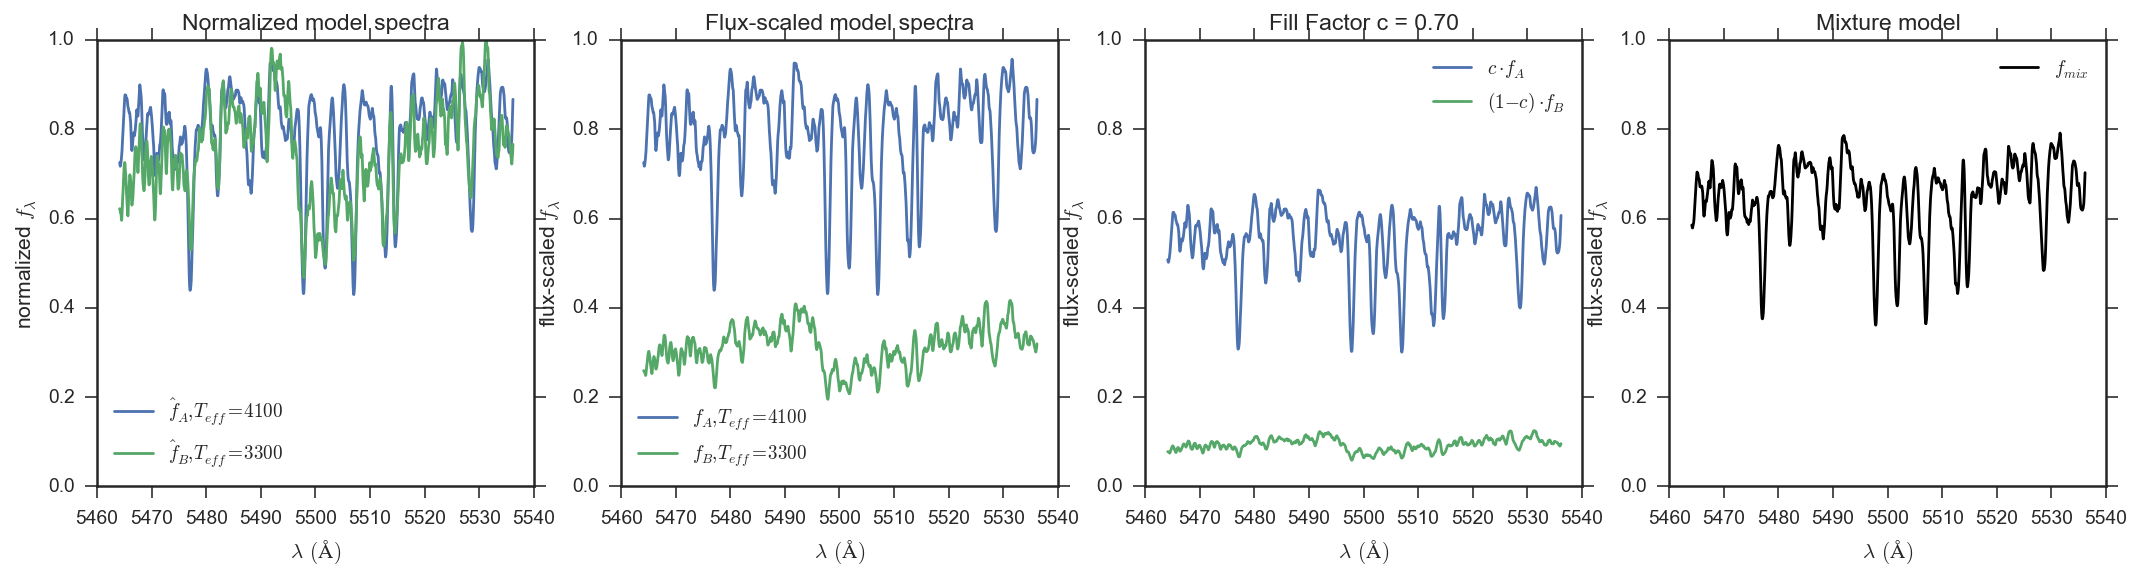

In [8]:
plt.figure(figsize=(18, 4))
plt.subplot('141')
plt.title('Normalized model spectra')
plt.plot(wl, fl_ma, label='$\hat f_{A}, T_{eff} = 4100$')
plt.plot(wl, fl_mb_raw, label='$\hat f_{B}, T_{eff} = 3300$')
plt.ylim(0,1.0)
plt.legend(loc='best')
plt.xlabel('$\lambda \,(\AA)$')
plt.ylabel('normalized $f_\lambda$')

plt.subplot('142')
plt.title('Flux-scaled model spectra')
plt.plot(wl, fl_ma, label='$f_{A}, T_{eff} = 4100$')
plt.plot(wl, fl_mb, label='$f_{B}, T_{eff} = 3300$')
plt.ylim(0,1.0)
plt.legend(loc='best')
plt.xlabel('$\lambda \,(\AA)$')
plt.ylabel('flux-scaled $f_\lambda$')

plt.subplot('143')
plt.title('Fill Factor c = {:.2f}'.format(c))
plt.plot(wl, fl_ma * c, label='$c \cdot f_{A}$')
plt.plot(wl, fl_mb * (1-c), label='$(1-c) \cdot f_{B}$')
plt.ylim(0,1.0)
plt.legend(loc='best')
plt.xlabel('$\lambda \,(\AA)$')
plt.ylabel('flux-scaled $f_\lambda$')

plt.subplot('144')
plt.title('Mixture model')
plt.plot(wl, mmix, 'k', label='$f_{mix}$')
plt.ylim(0,1.0)
plt.legend(loc='best')
plt.xlabel('$\lambda \,(\AA)$')
plt.ylabel('flux-scaled $f_\lambda$')

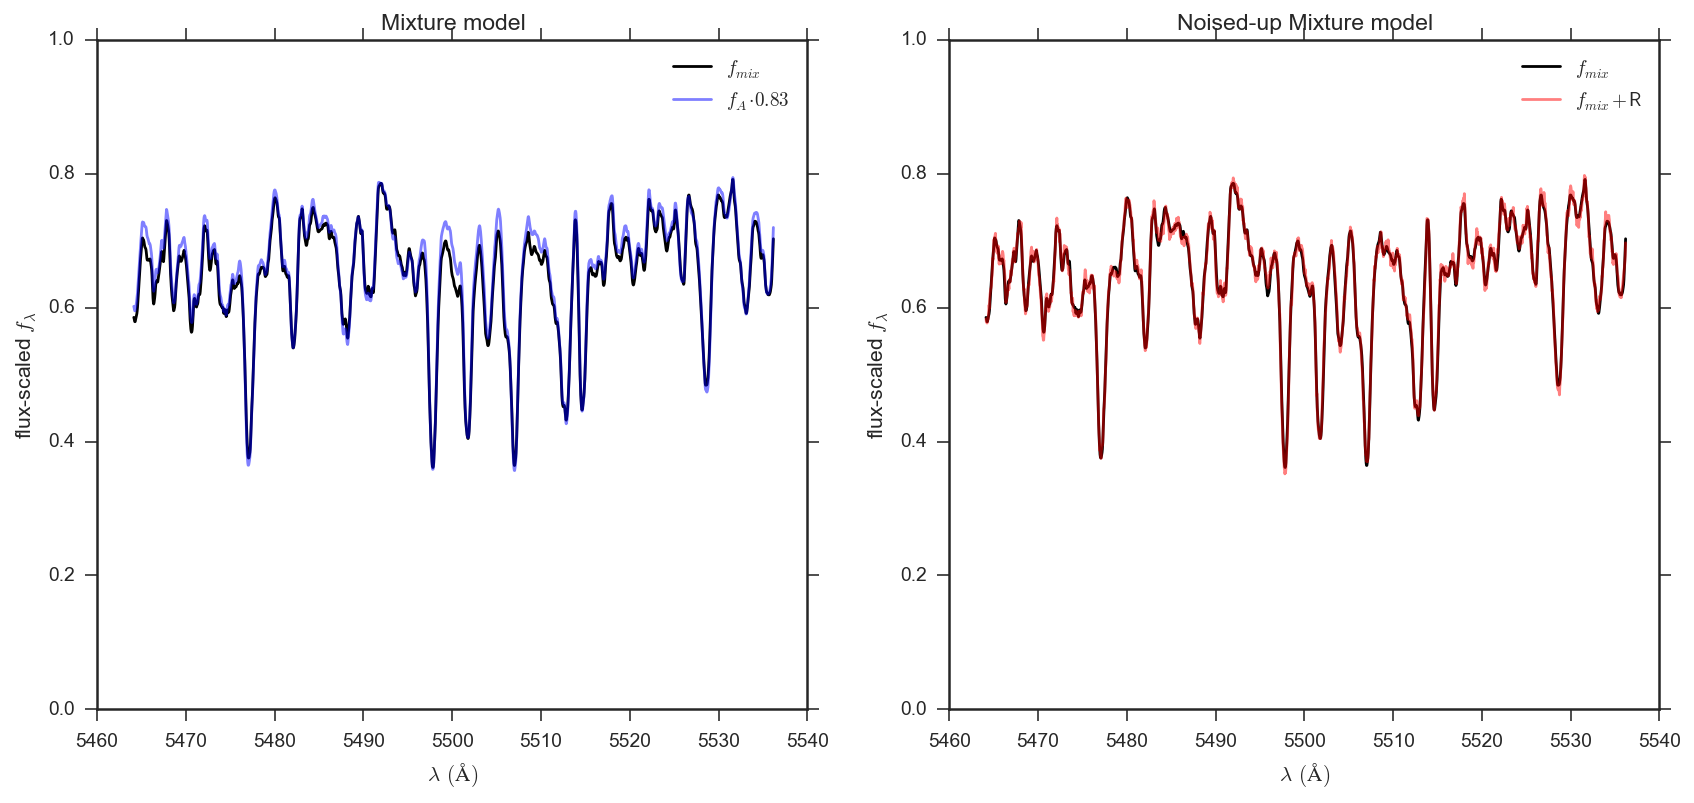

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot('121')
plt.title('Mixture model')
plt.plot(wl, mmix, 'k', label='$f_{mix}$')
plt.plot(wl, fl_ma*0.83, 'b', alpha=0.5, label='$f_{A} \cdot 0.83$')
plt.ylim(0,1.0)
plt.legend(loc='best')
plt.xlabel('$\lambda \,(\AA)$')
plt.ylabel('flux-scaled $f_\lambda$')

plt.subplot('122')
plt.title('Noised-up Mixture model')
plt.plot(wl, mmix, 'k', label='$f_{mix}$')
plt.plot(wl, mmix_noised, 'r', alpha=0.5, label='$f_{mix} + \mathsf{R}$')
plt.ylim(0,1.0)
plt.legend(loc='best')
plt.xlabel('$\lambda \,(\AA)$')
plt.ylabel('flux-scaled $f_\lambda$')

# Prepare for automation
### We will save the default config and phi values to a DataFrame.
This will allow us to compare what we get from the fits to what we input.

In [10]:
import pandas as pd

In [11]:
import yaml

In [12]:
def fill_DataFrame(config, phi):
    dict_out = {
        "logg":config['Theta']['grid'][1],
        "Fe_H":config['Theta']['grid'][2],
        "logOmega":config['Theta']['logOmega'],
        "vsini":config['Theta']['vsini'],
        "vz":config['Theta']['vz'],
        "Av":config['Theta']['Av'],
        "logAmp":phi['logAmp'],
        "sigAmp":phi['sigAmp'],
        "ll":phi['l'],
        "cheb1":phi['cheb'][0],
        "cheb2":phi['cheb'][1],
        "cheb3":phi['cheb'][2]
    }
    return dict_out

In [13]:
os.chdir('/Users/gully/GitHub/welter/notebooks/')

In [14]:
df = pd.DataFrame()
for i in range(0, 34+1):
    os.chdir('../sf/eo{:03d}/'.format(i))
    if os.path.exists('config.yaml') & os.path.exists('s0_o0phi.json'):
        #Let's just record the starting values of the config.yaml files in a DataFrame.
        with open('config.yaml', 'r') as f:
            config = yaml.load(f)
        with open('s0_o0phi.json', 'r') as f:
            phi = json.load(f)

        this_df = pd.DataFrame(fill_DataFrame(config, phi), index=[i])
        df = df.append(this_df)
    os.chdir('/Users/gully/GitHub/welter/notebooks/')

In [15]:
df.head()

,Av,Fe_H,cheb1,cheb2,cheb3,ll,logAmp,logOmega,logg,sigAmp,vsini,vz
0,0,0,0.045284,0.011039,0.038885,72.114952,-1.4,-0.300486,3.5,4.424212,28.5,15.6
1,0,0,-0.027112,-0.008630,-0.005690,41.962921,-1.4,-0.207626,3.5,3.773452,28.5,15.6
2,0,0,-0.005194,0.030180,0.018902,46.100685,-1.4,-0.111302,3.5,3.315826,28.5,15.6
3,0,0,0.001950,0.010707,-0.051384,43.088070,-1.4,-0.090601,3.5,2.182574,28.5,15.6
4,0,0,-0.025719,-0.027724,-0.000678,48.723873,-1.4,-0.090843,3.5,2.260994,28.5,15.6


# TODO Save to a file:

In [16]:
df.to_csv('../data/analysis/ESPaDOnS_mixture_params.csv')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [17]:
sf_dat = pd.read_csv('../data/analysis/IGRINS_ESPaDOnS_run01_last10kMCMC.csv')
sf_dat.rename(columns={"m_val_x":"m_val"}, inplace=True)
del sf_dat['m_val_y']

In [18]:
sf_dat.head(6)

,m_val,number,wl_center,wl_end,wl_start,Teff_05p,Teff_50p,Teff_95p,logg_05p,logg_50p,...,SA_05p,SA_50p,SA_95p,LA_05p,LA_50p,LA_95p,ll_05p,ll_50p,ll_95p,m_int
0,0,0,5180.62500,5199.9292,5161.3208,3671.597583,3734.931152,3918.759131,3.757152,3.929592,...,4.130559,4.424212,4.735918,-1.030014,-0.915195,-0.820424,56.789884,72.114952,82.728920,0
1,1,1,5231.25700,5262.5311,5199.9829,3910.707983,3991.772217,4062.312549,3.531365,3.655367,...,3.515317,3.773452,4.024213,-1.249743,-1.176541,-1.078180,35.295181,41.962921,52.413920,1
2,2,2,5294.98655,5327.4005,5262.5726,3850.192407,3990.523193,4186.905322,3.815876,3.936076,...,3.121204,3.315826,3.529300,-1.314615,-1.223884,-1.141970,36.250294,46.100685,56.028513,2
3,3,3,5360.99580,5394.5496,5327.4420,3846.459961,3923.694824,3995.909888,3.585957,3.762359,...,2.058792,2.182574,2.324363,-1.328933,-1.267863,-1.195140,37.950161,43.088070,49.906529,3
4,4,4,5429.35055,5464.0826,5394.6185,3727.496973,3812.548828,3867.507104,3.572361,3.817147,...,2.110130,2.260994,2.406161,-1.200368,-1.147594,-1.093094,44.042196,48.723873,53.670507,4
5,5,5,5500.15715,5536.1810,5464.1333,4103.650000,4165.299805,4224.340332,3.734627,3.857922,...,1.479642,1.573297,1.666605,-1.439106,-1.392670,-1.343042,27.386238,30.628227,34.625260,5


### Comparison: What is in the config files, versus what we learned from 20,000 MCMC samples.

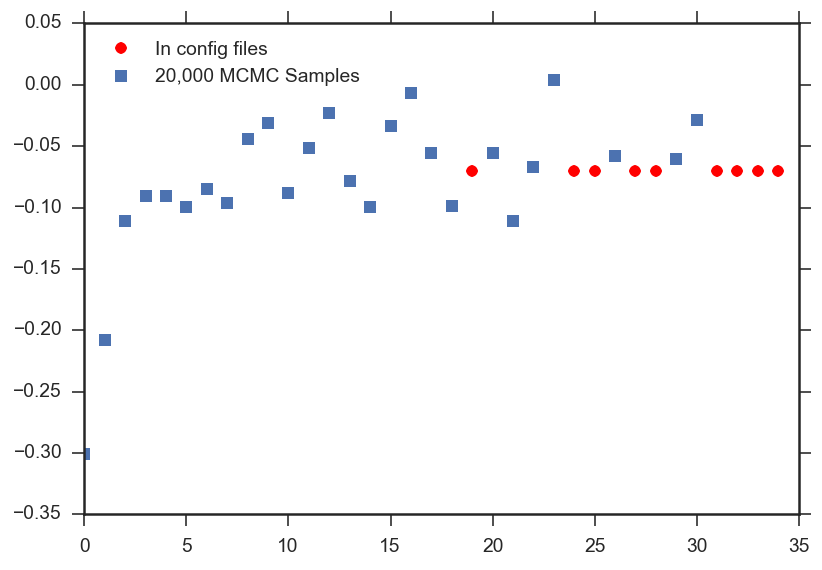

In [19]:
plt.plot(df.index.values, df.logOmega, 'ro', label = 'In config files')
plt.plot(df.index.values, sf_dat.logO_50p, 's', label = '20,000 MCMC Samples')
plt.legend(loc='best');